In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 50
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))

# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from IPython.display import Image
from IPython import get_ipython
ipython = get_ipython()

# Autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload

%autoreload 2

# Ignore exceptions
import expectexception

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# Visualizations
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode(connected=True)

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

# Activate the automatic conversion for pandas
from rpy2.robjects import pandas2ri
pandas2ri.activate()

# Load the needed extension for the %%R cell magic
%load_ext rpy2.ipython

# Suppress rpy2 runtime warnings
import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore", category=RRuntimeWarning)

# Load ipywidgets module
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

In [3]:
%%R

# Visualization
library(ggplot2)
library(ggalt)
library(ggExtra)
library(ggcorrplot)
library(ggthemes)
library(ggdendro)
library(GGally)
library(ggrepel)
theme_set(theme_light())

# Tidyverse library
library(scales)
library(dplyr)
library(tidyr)
library(forcats)
library(readr)
library(purrr)

# String manipulations
library(tools)
library(lubridate)

# Machine Learning Related
library(car)
library(caTools)
library(pROC)

# Misc
library(psych)
library(mice)

In [4]:
# 2a. Import dataset

train = pd.read_csv('../../Homework Data/Homework 4 Data/aps_failure_training_set.csv', 
                    na_values='na', skiprows=20)
test = pd.read_csv('../../Homework Data/Homework 4 Data/aps_failure_test_set.csv', 
                    na_values='na', skiprows=20)

In [5]:
X_train = train.iloc[:, 1:]
y_train = train.iloc[:, 0]
X_test = test.iloc[:, 1:]
y_test = test.iloc[:, 0]

In [6]:
y_train = y_train.apply(lambda x: 0 if x=='neg' else 1)
y_test = y_test.apply(lambda x: 0 if x=='neg' else 1)

In [7]:
# 2bi. Data imputation

from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer

itimp = IterativeImputer(verbose=2)
X_train_imp = itimp.fit_transform(X_train)
X_test_imp = itimp.fit_transform(X_test)

[IterativeImputer] Completing matrix with shape (60000, 170)
[IterativeImputer] Ending imputation round 1/10, elapsed time 140.94
[IterativeImputer] Ending imputation round 2/10, elapsed time 292.12
[IterativeImputer] Ending imputation round 3/10, elapsed time 452.49
[IterativeImputer] Ending imputation round 4/10, elapsed time 595.78
[IterativeImputer] Ending imputation round 5/10, elapsed time 733.39
[IterativeImputer] Ending imputation round 6/10, elapsed time 883.44
[IterativeImputer] Ending imputation round 7/10, elapsed time 1028.41
[IterativeImputer] Ending imputation round 8/10, elapsed time 1196.61
[IterativeImputer] Ending imputation round 9/10, elapsed time 1342.60
[IterativeImputer] Ending imputation round 10/10, elapsed time 1491.84


/opt/anaconda3/lib/python3.7/site-packages/sklearn/impute/_iterative.py:603: ConvergenceWarning:

[IterativeImputer] Early stopping criterion not reached.



[IterativeImputer] Completing matrix with shape (16000, 170)
[IterativeImputer] Ending imputation round 1/10, elapsed time 40.88
[IterativeImputer] Ending imputation round 2/10, elapsed time 78.27
[IterativeImputer] Ending imputation round 3/10, elapsed time 117.19
[IterativeImputer] Ending imputation round 4/10, elapsed time 157.79
[IterativeImputer] Ending imputation round 5/10, elapsed time 199.10
[IterativeImputer] Ending imputation round 6/10, elapsed time 236.80
[IterativeImputer] Ending imputation round 7/10, elapsed time 274.01
[IterativeImputer] Ending imputation round 8/10, elapsed time 313.44
[IterativeImputer] Ending imputation round 9/10, elapsed time 355.10
[IterativeImputer] Ending imputation round 10/10, elapsed time 389.46


/opt/anaconda3/lib/python3.7/site-packages/sklearn/impute/_iterative.py:603: ConvergenceWarning:

[IterativeImputer] Early stopping criterion not reached.



This time I experiment with sklearn's Iterative Imputer which is essentially the 'norm' method from the MICE package, which incorporates Bayesian Regression techniques. Other simple imputation methods include mean, mode and median imputation.

Note that the above imputations haven't reached the minimum epsilon for early stopping, indicating the sub-optimal imputation quality due to insufficient iteration times. But for time's sake, we'll stick with this.

In [8]:
# 2bii. Coefficient of Variation

from sklearn.preprocessing import Normalizer

nml = Normalizer() # Normalize the variables so that CV makes more sense
X_train_imp_norm = nml.fit_transform(X_train_imp.T).T

In [9]:
X_train_imp_norm = pd.DataFrame(X_train_imp_norm, columns=X_train.columns)

COV = X_train_imp_norm.apply(lambda x: np.std(x)/np.mean(x)).sort_values(ascending=False)
COV.head(20)

ab_000   2987.821
ea_000    754.472
ac_000    538.320
av_000    342.729
cg_000    288.804
cs_009    235.060
ad_000    184.329
cf_000    184.000
co_000    183.932
dl_000    155.465
dm_000    154.221
cr_000    153.180
ch_000    112.583
ay_009    100.069
dh_000     95.052
as_000     94.069
bz_000     93.582
ak_000     92.814
ag_000     91.753
ce_000     78.581
dtype: float64

In [10]:
# 2biii. Correlation plot

X_cor = X_train_imp_norm.corr()

In [11]:
%%R -i X_cor

# Plot
gg=ggcorrplot(X_cor,
              type = "lower",
              outline.col='white',
              colors = c("tomato2", "white", "springgreen3"),
              legend.title='Correlation',
              title="Correlogram of training set features",
              ggtheme=theme_classic,
              tl.cex=0) # Suppress Variable name


png(file='./HW4_image/corr2.png', width=1000, height=1000)
gg

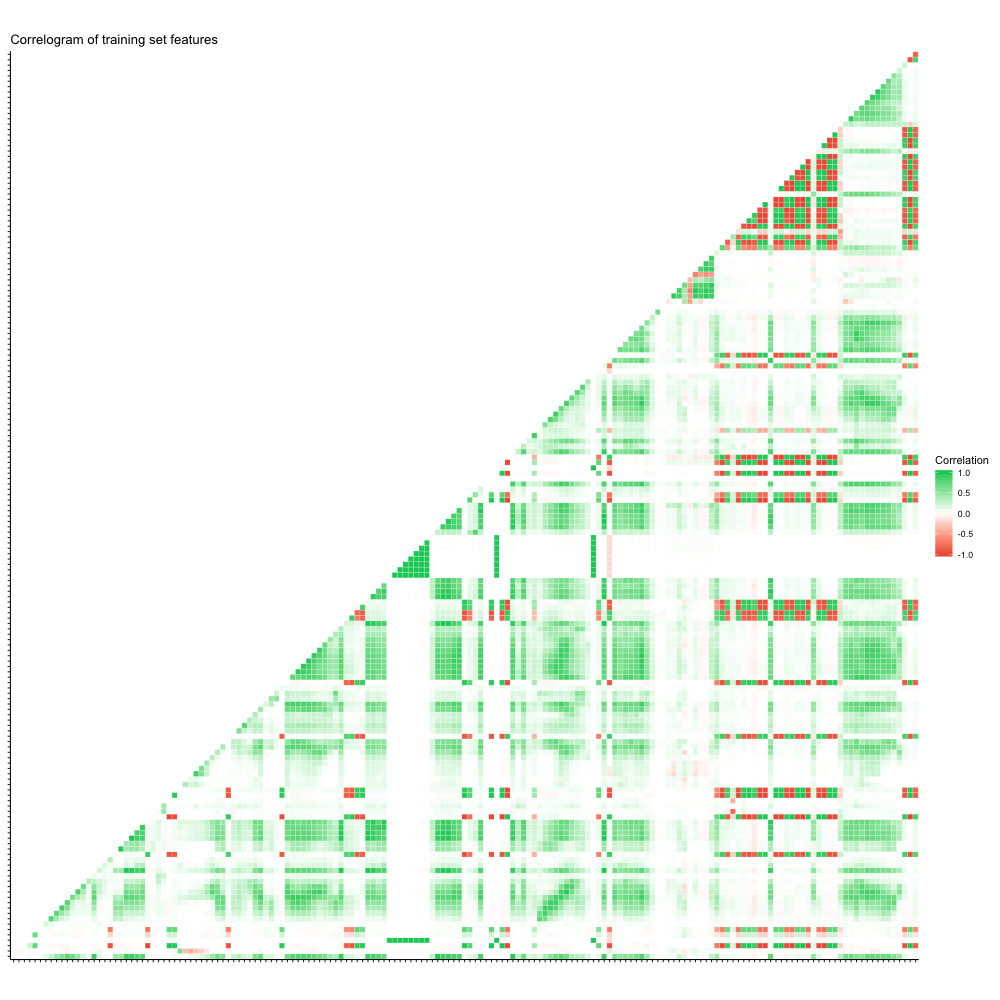

In [12]:
Image('./HW4_image/corr2.png')

In [13]:
# 2biv. Scatterplot and boxplot for high CV variables

colnames_13 = COV.head(13).index
highCV_13 = pd.concat([X_train_imp_norm.loc[:, COV.head(13).index], y_train], axis=1)

In [14]:
%%R -i highCV_13,colnames_13

g = highCV_13 %>%
    gather(-one_of('class'), key='variable', value='value')

g$variable = ordered(g$variable, levels=colnames_13)
g$class = factor(g$class)

gg=ggplot(g, aes(variable, value)) +
     geom_boxplot(outlier.shape=NA) +
     geom_jitter(aes(col=class), width=.05) +
     ylim(c(-0.15, 0.2)) +
     theme(axis.text.x = element_text(angle=45, vjust=0.5)) +
     labs(title="Distribution of features with top 13 CV",
          x="Variable")

png(file='./HW4_image/scatter2.png', width=1000, height=600)
gg

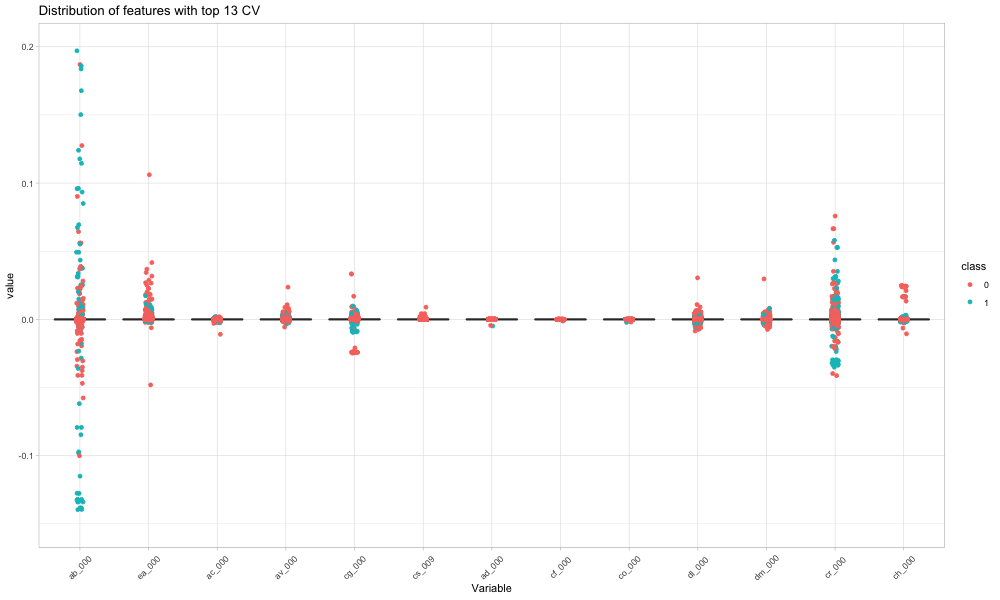

In [15]:
Image('./HW4_image/scatter2.png')

Having the majority of samples close to 0, we can see the boxplots being squashed towards the middle of the y-axis, rendering them un-interpretable.

As far as the distribution of the target variable is concerned, **it's hard to make any conclusions** regarding the significance of the features because they are scattered along the y-axis with little to no clear patterns. 

In [16]:
# 2bv. Inspection of target variables

y_train.value_counts()
y_test.value_counts()

0    59000
1     1000
Name: class, dtype: int64

0    15625
1      375
Name: class, dtype: int64

We have serious class imbalance in both train and test set.

In [17]:
# h2o.cluster().shutdown()

In [18]:
# 2c. Random Forest using H2O

import h2o

h2o.init() # Initialize a cluster

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "12.0.1" 2019-04-16; Java(TM) SE Runtime Environment (build 12.0.1+12); Java HotSpot(TM) 64-Bit Server VM (build 12.0.1+12, mixed mode, sharing)
  Starting server from /opt/anaconda3/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/5f/fqq6rg5n6s941_p7h10lx3sm0000gn/T/tmp4x7u1jmy
  JVM stdout: /var/folders/5f/fqq6rg5n6s941_p7h10lx3sm0000gn/T/tmp4x7u1jmy/h2o_nelson_started_from_python.out
  JVM stderr: /var/folders/5f/fqq6rg5n6s941_p7h10lx3sm0000gn/T/tmp4x7u1jmy/h2o_nelson_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,America/Los_Angeles
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.8
H2O cluster version age:,11 days
H2O cluster name:,H2O_from_python_nelson_pfu1qf
H2O cluster total nodes:,1
H2O cluster free memory:,4 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


In [19]:
train_h2o = h2o.H2OFrame(train) # Convert pandas dataframe to H2O Frames
test_h2o = h2o.H2OFrame(test)

X_col = train_h2o.col_names[1:] # Extract feature column names
y_col = train_h2o.col_names[0]  # Extract target column name

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [20]:
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.grid.grid_search import H2OGridSearch

# RF hyperparameters (note that it can only contain iterables)
rf_params = {
    'max_depth': np.arange(10, 20, 2, dtype=int).tolist(), 
    'sample_rate': [0.8, 0.9, 1.0], # Row subsampling
    'col_sample_rate_per_tree': [0.9, 1.0], # Column subsampling on a tree level
    'min_split_improvement': [1e-3, 1e-4, 1e-5] # Minimum relative improvement in squared error reduction
}

# Specifying additional search (stopping) criteria for the collection of forests
search_criteria = {
    'strategy': 'RandomDiscrete', # Specify a random search
    'max_runtime_secs': 1800, # Run for 30 minutes at max
    'stopping_rounds': 10,
    'stopping_metric': 'auc', # Use AUC for stopping metric
    'stopping_tolerance': 1e-3,
    'max_models': 36, # Produce at max 36 forests
    'seed': 408
}

# Instantiate the RandomSearch, specifying stopping criteria for individual forest
rf_grid = H2OGridSearch(model=H2ORandomForestEstimator(
                                    mtries=-1,  # Use sqrt(col_num) at each depth
                                    stopping_rounds=5,
                                    stopping_tolerance = 1e-3,
                                    stopping_metric='auc'),    
                        grid_id='rf_grid',      
                        hyper_params=rf_params, 
                        search_criteria=search_criteria) 

rf_grid.train(X_col, y_col, training_frame=train_h2o, nfolds=5, ntrees=200)

drf Grid Build progress: |████████████████████████████████████████████████| 100%


In [21]:
# Get the grid results, sorted by validation AUC

rf_gridperf = rf_grid.get_grid(sort_by='auc', decreasing=True)

In [22]:
# Grab the top GBM model, chosen by validation AUC

best_rf = rf_gridperf.models[0]

In [23]:
# Confusion matrix and total missclassification for train set

best_rf.confusion_matrix()


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4595253779404778: 


,,neg,pos,Error,Rate
0,neg,58892.000,108.000,0.0018,(108.0/59000.0)
1,pos,262.000,738.000,0.262,(262.0/1000.0)
2,Total,59154.000,846.000,0.0062,(370.0/60000.0)


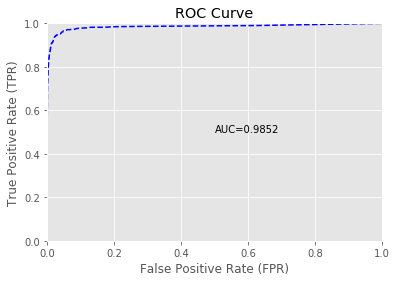

In [24]:
# AUC and ROC for train set

best_rf.model_performance().plot()

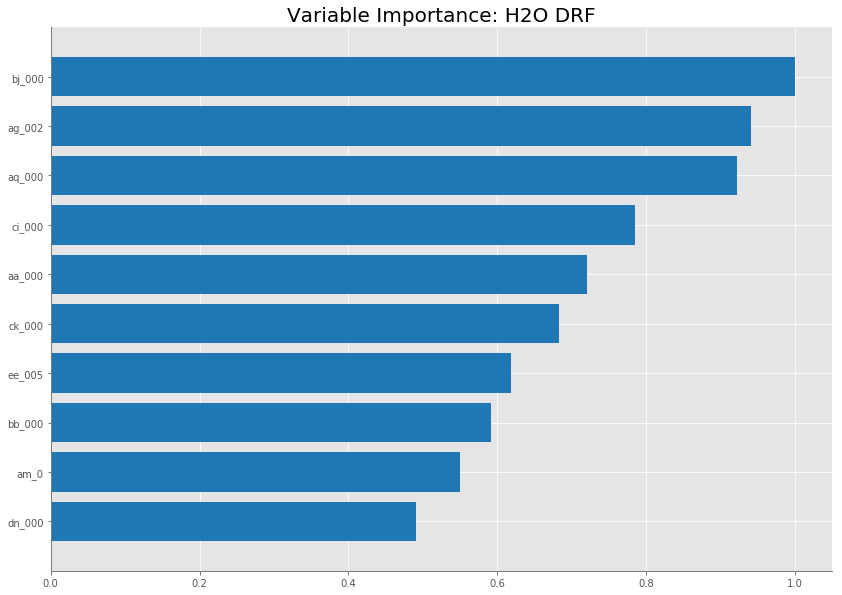

In [25]:
# Variable Importance Graph

best_rf.varimp_plot()

In [26]:
# Now let's evaluate the model performance on the test set

best_test = best_rf.model_performance(test_h2o)

In [27]:
# Confusion matrix and total missclassification for test set

best_test.confusion_matrix()


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3426345262726148: 


,,neg,pos,Error,Rate
0,neg,15588.000,37.000,0.0024,(37.0/15625.0)
1,pos,64.000,311.000,0.1707,(64.0/375.0)
2,Total,15652.000,348.000,0.0063,(101.0/16000.0)


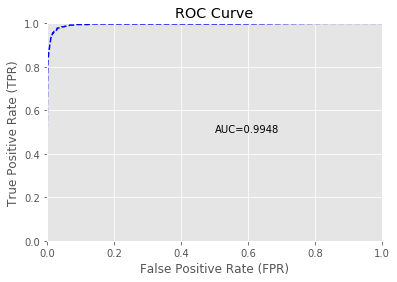

In [28]:
# AUC and ROC for test set

best_test.plot()

In [29]:
# OOB error

best_test.mse()

0.006285700461371132

The OOB error closely resembles the test error.

In [54]:
# 2d. Random Forest Using H2O with compensation for class imbalance

# Instantiate the RandomSearch, specifying stopping criteria for individual forest
rf_grid2 = H2OGridSearch(model=H2ORandomForestEstimator(
                                     mtries=-1,  # Use sqrt(col_num) at each depth
                                     stopping_rounds=5,
                                     stopping_tolerance = 1e-3,
                                     stopping_metric='auc',
                                     balance_classes=True, # Perform up-sampling and down-sampling
                                     max_after_balance_size=1.0), # Retain original sample size = 60000
                        grid_id='rf_grid2',      
                        hyper_params=rf_params, # Use the same hyperparameter set as above
                        search_criteria=search_criteria)

rf_grid2.train(X_col, y_col, training_frame=train_h2o, nfolds=5, ntrees=200)

drf Grid Build progress: |████████████████████████████████████████████████| 100%


In [55]:
# Get the grid results, sorted by validation AUC

rf_gridperf2 = rf_grid2.get_grid(sort_by='auc', decreasing=True)

In [78]:
# Grab the top GBM model, chosen by validation AUC

best_rf2 = rf_gridperf2.models[0]

In [79]:
# Confusion matrix and total missclassification for train set

best_rf2.confusion_matrix()


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.17491386269992026: 


,,neg,pos,Error,Rate
0,neg,49744.000,111.000,0.0022,(111.0/49855.0)
1,pos,235.000,9900.000,0.0232,(235.0/10135.0)
2,Total,49979.000,10011.000,0.0058,(346.0/59990.0)


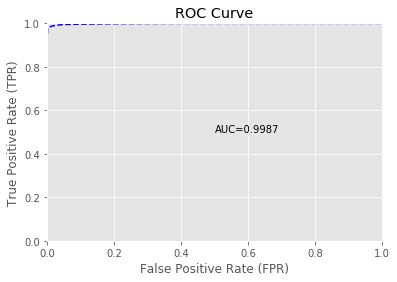

In [80]:
# AUC and ROC for train set

best_rf2.model_performance().plot()

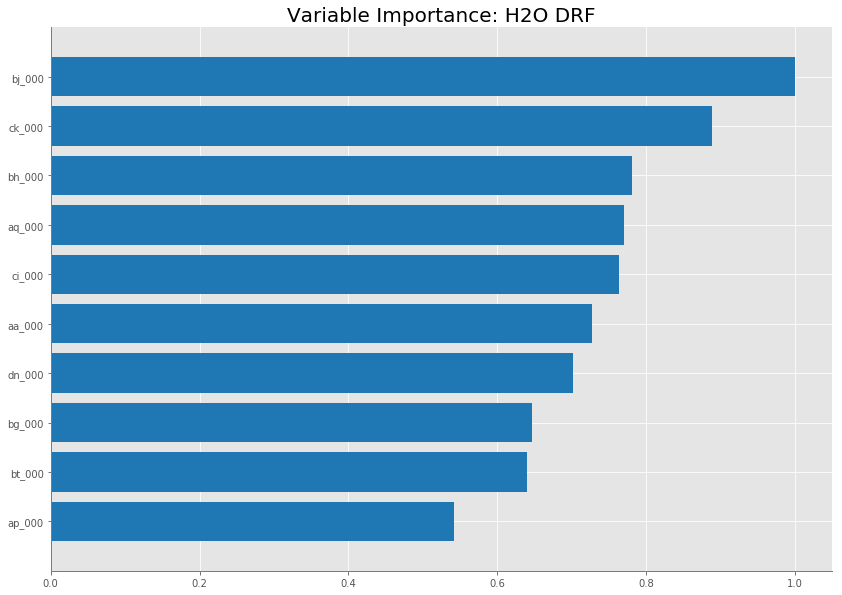

In [81]:
# Variable Importance Graph

best_rf2.varimp_plot()

In [82]:
# Now let's evaluate the model performance on the test set

best_test2 = best_rf2.model_performance(test_h2o)

In [83]:
# Confusion matrix and total missclassification for test set

best_test2.confusion_matrix()


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.06847519513949703: 


,,neg,pos,Error,Rate
0,neg,15509.000,116.000,0.0074,(116.0/15625.0)
1,pos,52.000,323.000,0.1387,(52.0/375.0)
2,Total,15561.000,439.000,0.0105,(168.0/16000.0)


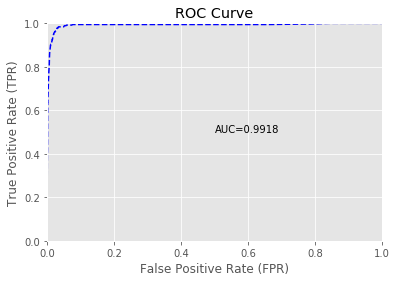

In [84]:
# AUC and ROC for test set

best_test2.plot()

In [85]:
# OOB error

best_test2.mse()

0.012677707264736984

The OOB error, again closely resembles the test error.

We have a **performance boost in terms of classifying the positive class**; the test error went down from 0.171 to 0.139, which is expected because of the up-sampling. On the other hand, the error rate in classifying the negative class went triple from 0.0024 to 0.0074, which **makes the imbalance compensated Random Forest a worse classifier in terms of overall accuracy**.

One possible explanation is that **down-sampling of the negative class** has a negative impact on the classifier. Other explanation is that the **distribution of target variables in the test set now differs greatly from the train set**, which may or may not have impacted the classifier adversely.

In [86]:
h2o.cluster().shutdown()

H2O session _sid_95de closed.


In [87]:
pd.concat([pd.DataFrame(X_train_imp, columns=X_train.columns), y_train], axis=1)\
.to_csv('imputed_data/imputed_train.csv', index=False)

pd.concat([pd.DataFrame(X_test_imp, columns=X_train.columns), y_test], axis=1)\
.to_csv('imputed_data/imputed_test.csv', index=False)

The remaining part of the homework is contained in Homework 4c :)